In [20]:
import sys
from pathlib import Path
import yaml
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchdyn.core import NeuralODE
from torch.utils.data import Dataset, DataLoader

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

import warnings
warnings.simplefilter("ignore", FutureWarning)

from field_model import *
from model_distances import vectorize_model_params

In [2]:
# load config files for data and pipeline
with open("config.yaml", "r") as f1:
    config = yaml.full_load(f1)

with open("../../data/dataset_params.yaml") as f2:
    data_params = yaml.full_load(f2)

device = torch.device(config["device"])

# dir with trajectories Datasets
traj_dir = Path("trajectories/")
if not traj_dir.exists():
    raise FileNotFoundError("No Datasets created.")

# ode models
models_dir = Path("models/")
if not models_dir.exists():
    raise FileNotFoundError("No models created.")

In [ ]:
num_activities = len(data_params["activity_codes"])

distr_dict = {}
test_dict = {}

In [ ]:
for activity in data_params["activity_codes"]:
    distr_dict[activity] = []

    for state_dict_file in models_dir.glob(f"{activity}*"):
        # load model
        vector_field = eval(config["model_cls"])(config["trajectory_dim"], **config["model_params"])
        ode_model = NeuralODE(vector_field, solver='rk4').to(device)
        ode_model.load_state_dict(torch.load(state_dict_file))

        # save model params
        distr_dict[activity].append(
            vectorize_model_params(ode_model)
        )

    distr_dict[activity] = torch.stack(distr_dict[activity]).cpu().numpy()

    # train/test split
    num_train_params = int(len(distr_dict[activity]) * (1 - config["test_ratio"]))
    test_dict[activity] = distr_dict[activity][num_train_params:]
    distr_dict[activity] = distr_dict[activity][:num_train_params]

In [16]:
# build kNN
knn_classifier = KNeighborsClassifier(
    n_neighbors=10,
    weights="distance",
    n_jobs=4
)

In [17]:
# fit kNN
X_train = np.concat(list(distr_dict.values()))

num_repeats = [distr_dict[activity].shape[0] for activity in data_params["activity_codes"]]
y_train = np.arange(num_activities).repeat(num_repeats)

knn_classifier.fit(
    X_train,
    y_train
)

KNeighborsClassifier(n_jobs=4, n_neighbors=10, weights='distance')

In [18]:
# classify test models
for activity_ind, activity in enumerate(data_params["activity_codes"]):
    print(f"Classifing {activity}")

    test_params = test_dict[activity]
    prediction = knn_classifier.predict(test_params)
    print(f"Accuracy = {(prediction == activity_ind).mean()}")

Classifing dws
Accuracy = 0.3333333333333333
Classifing ups
Accuracy = 0.4
Classifing wlk
Accuracy = 0.4
Classifing jog
Accuracy = 0.2
Classifing std
Accuracy = 0.0
Classifing sit
Accuracy = 0.3


In [40]:
# use tsne to vizualize ML-estimators

tSNE = TSNE(
    n_components=2,
    perplexity=15
)

X_train_viz = tSNE.fit_transform(X_train)

In [41]:
X_train_viz.shape

(285, 2)

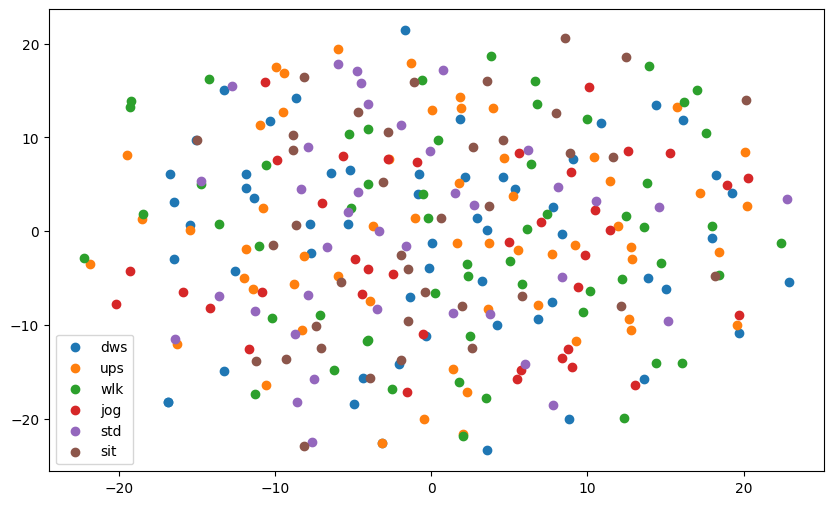

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))

for activity_ind, activity in enumerate(data_params["activity_codes"]):
    act_points = X_train_viz[y_train == activity_ind]

    ax.scatter(*act_points.T, label=activity)

ax.legend()